# Variations of theoretical RLNM

In [41]:
from obspy import * 
from pandas import *
from os import listdir

import netCDF4 as nc
import numpy as np

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Configurations

In [42]:
config = {}

config['workdir'] = "/export/data/LNM/data/"

config['love_phase_nc'] = "PHASE_VELOCITY_MODEL/LovePhaseVelocity.nc"
config['rayleigh_phase_nc'] = "PHASE_VELOCITY_MODEL/RayleighPhaseVelocity.nc"

config['datadir_models'] = config['workdir']+"MODELS/"

config['noise_models'] =  config['workdir']+"MODELS/"+"noise_models.npz"

config['datadir_spectra'] = config['workdir']+"2018/"

config['spectra_files'] = listdir(config['datadir_spectra'])

config['outdir'] = config['workdir']+"STATS/"

config['outdir_figures'] = "/home/brotzer/Documents/ROMY/LowNoiseModel/figures/"

config['type'] = "Rayleigh" ## Love | Rayleigh 

config['period_lower'] = 2.5
config['period_upper'] = 300

### Read Low/High Noise Models

In [43]:
tmp = np.load(config['noise_models'])
nm_periods, nlnm, nhnm = tmp['model_periods'], tmp['low_noise'], tmp['high_noise']; del tmp

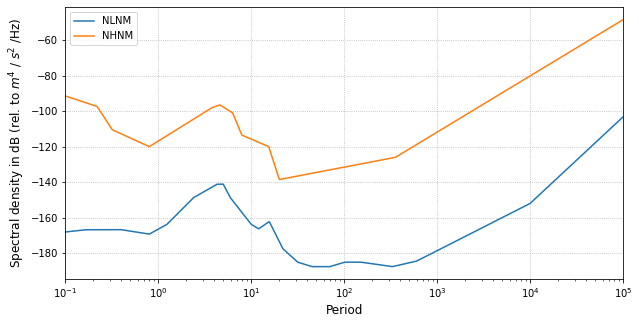

In [44]:
def __plot_noise_models(periods, nlnm, nhnm):
    plt.figure(figsize=(10,5))

    plt.semilogx(periods, nlnm, label="NLNM")
    plt.semilogx(periods, nhnm, label="NHNM")
    
    plt.xlabel('Period', fontsize=12)
    plt.ylabel(r'Spectral density in dB (rel. to $m^4$ / $s^2$ /Hz)', fontsize=12)
    
    plt.grid(ls=":")
    plt.legend()
    plt.xlim(periods[-1],periods[0])
    
    plt.show();
    
__plot_noise_models(nm_periods, nlnm, nhnm)

In [45]:
def __cutter(x, y, x_lower, x_upper):
    indices = []
    for i, k in enumerate(x):
        if k >= x_lower and k <= x_upper:
            indices.append(i)
    print(f" -> cutting from {x[indices[0]]} - {x[indices[-1]]}")
    return x[indices[0]:indices[-1]], y[indices[0]:indices[-1]] ,indices

In [46]:
nm_periods, nlnm, ind = __cutter(nm_periods,nlnm,1,200)

 -> cutting from 199.526 - 1.00462


### Read veloctiy profiles

In [47]:
vphase_rayl_land = read_pickle(config['workdir']+"PHASE_VELOCITY_MODEL/Rayleigh_Average/"+"RAYLEIGH_vphase_land_only.pkl")
vphase_love_land = read_pickle(config['workdir']+"PHASE_VELOCITY_MODEL/Love_Average/"+"LOVE_vphase_land_only.pkl")

vphase_rayl_ocean = read_pickle(config['workdir']+"PHASE_VELOCITY_MODEL/Rayleigh_Average/"+"RAYLEIGH_vphase_ocean_only.pkl")
vphase_love_ocean = read_pickle(config['workdir']+"PHASE_VELOCITY_MODEL/Love_Average/"+"LOVE_vphase_ocean_only.pkl")

In [48]:
periods = vphase_rayl['periods']

## rayleigh land conversion from km/s to m/s
vphase_rayl_land_median = np.interp(nm_periods, periods, vphase_rayl_land['vphase_median'])*1000
vphase_rayl_land_max = np.interp(nm_periods, periods, vphase_rayl_land['vphase_max'])*1000
vphase_rayl_land_std = np.interp(nm_periods, periods, vphase_rayl_land['vphase_std'])*1000
vphase_rayl_land_mad = np.interp(nm_periods, periods, vphase_rayl_land['vphase_mad'])*1000

## love land conversion from km/s to m/s
vphase_love_land_median = np.interp(nm_periods, periods,vphase_love_land['vphase_median'])*1000
vphase_love_land_max = np.interp(nm_periods, periods,vphase_love_land['vphase_max'])*1000
vphase_love_land_std = np.interp(nm_periods, periods,vphase_love_land['vphase_std'])*1000
vphase_love_land_mad = np.interp(nm_periods, periods,vphase_love_land['vphase_mad'])*1000

## rayleigh ocean conversion from km/s to m/s
vphase_rayl_ocean_median = np.interp(nm_periods, periods,vphase_rayl_ocean['vphase_median'])*1000
vphase_rayl_ocean_max = np.interp(nm_periods, periods,vphase_rayl_ocean['vphase_max'])*1000
vphase_rayl_ocean_std = np.interp(nm_periods, periods,vphase_rayl_ocean['vphase_std'])*1000
vphase_rayl_ocean_mad = np.interp(nm_periods, periods,vphase_rayl_ocean['vphase_mad'])*1000

## love ocean conversion from km/s to m/s
vphase_love_ocean_median = np.interp(nm_periods, periods,vphase_love_ocean['vphase_median'])*1000
vphase_love_ocean_max = np.interp(nm_periods, periods,vphase_love_ocean['vphase_max'])*1000
vphase_love_ocean_std = np.interp(nm_periods, periods,vphase_love_ocean['vphase_std'])*1000
vphase_love_ocean_mad = np.interp(nm_periods, periods,vphase_love_ocean['vphase_mad'])*1000

## Compute Rotations and Conversions

In [49]:
def __conversion(data, informat=None, outformat=None):
    '''
    data:                  array 
    informat/outformat:    ASD, PSD, DB
    '''
    from numpy import log10, sqrt
    
    
    if informat == 'ASD' and outformat == 'PSD':
        return data**2
    
    elif informat == 'PSD' and outformat == 'ASD':
        return sqrt(data)

    elif informat == 'ASD' and outformat == 'DB':
        return 10*log10(data**2)
    
    elif informat == 'PSD' and outformat == 'DB':
        return 10*log10(data)
    
    elif informat == 'DB' and outformat == 'PSD':
        return 10**(data/10)
    
    elif informat == 'DB' and outformat == 'ASD':
        return sqrt(10**(data/10))
    
    else:
        print(" -> specified case not defined!")

In [50]:
snlnm = __conversion(nlnm, informat='DB', outformat='ASD')

rot_nlnm_rayl_land_med = __conversion(np.array(snlnm / vphase_rayl_land_median), informat='ASD', outformat='PSD')
rot_nlnm_rayl_land_max = __conversion(np.array(snlnm / vphase_rayl_land_max), informat='ASD', outformat='PSD')

rot_nlnm_love_land_med = __conversion(np.array(snlnm / vphase_love_land_median), informat='ASD', outformat='PSD')
rot_nlnm_love_land_max = __conversion(np.array(snlnm / vphase_love_land_max), informat='ASD', outformat='PSD')

rot_nlnm_rayl_ocean_med = __conversion(np.array(snlnm / vphase_rayl_ocean_median), informat='ASD', outformat='PSD')
rot_nlnm_rayl_ocean_max = __conversion(np.array(snlnm / vphase_rayl_ocean_max), informat='ASD', outformat='PSD')

rot_nlnm_love_ocean_med = __conversion(np.array(snlnm / vphase_love_ocean_median), informat='ASD', outformat='PSD')
rot_nlnm_love_ocean_max = __conversion(np.array(snlnm / vphase_love_ocean_max), informat='ASD', outformat='PSD')


## Plots

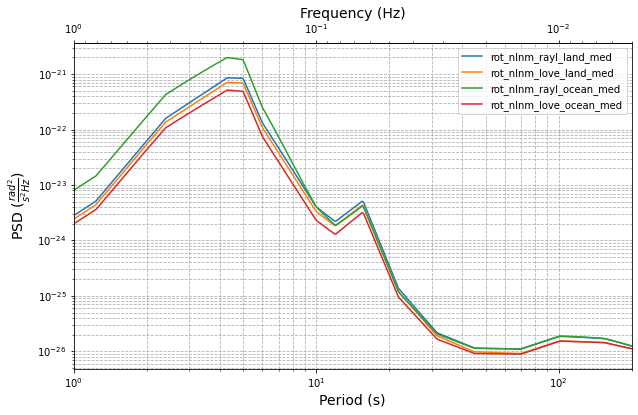

In [54]:
def __plot_rlnm():
    
    font = 14

    fig, ax = plt.subplots(1,1, figsize=(10,6))

    ax.plot(nm_periods, rot_nlnm_rayl_land_med, zorder=2, label="rot_nlnm_rayl_land_med")
#     ax.plot(nm_periods, rot_nlnm_rayl_land_max, zorder=2, label="rot_nlnm_rayl_land_max")
    
    ax.plot(nm_periods, rot_nlnm_love_land_med, zorder=2, label="rot_nlnm_love_land_med")
#     ax.plot(nm_periods, rot_nlnm_love_land_max, zorder=2, label="rot_nlnm_love_land_max")
    
    ax.plot(nm_periods, rot_nlnm_rayl_ocean_med, zorder=2, label="rot_nlnm_rayl_ocean_med")
#     ax.plot(nm_periods, rot_nlnm_rayl_ocean_max, zorder=2, label="rot_nlnm_rayl_ocean_max")
    
    ax.plot(nm_periods, rot_nlnm_love_ocean_med, zorder=2, label="rot_nlnm_love_ocean_med")
#     ax.plot(nm_periods, rot_nlnm_love_ocean_max, zorder=2, label="rot_nlnm_love_ocean_max")

    
    ax.set_xscale("log")
    ax.set_yscale("log")

#     ax.fill_between(nm_periods, y1=rot_nlnm_upper, y2=rot_nlnm_lower, color="lightgrey", zorder=2)

    ax.set_xlim(1, 200)
#     ax.set_ylim(7*10**-14, 10**-10)

    g = lambda x: 1/x
    ax2 = ax.secondary_xaxis("top", functions=(g,g))
    ax2.set_xlabel("Frequency (Hz)", fontsize=font)
    
    ax.grid(axis="both", which="both", ls="--", zorder=0)
    ax.legend()

    ax.set_xlabel("Period (s)", fontsize=font)
    ax.set_ylabel(r"PSD ($\frac{rad^2}{s^2 Hz}$)",fontsize=font)

    plt.show();
    return fig

fig = __plot_rlnm()

In [56]:
# fig.savefig(config['outdir_figures']+"RNLM_theory_variations"+".png", fmt="png", bbox_inches="tight", dpi=300, transparent=None)

## Write to File

In [53]:
# df_out = DataFrame()

# ## write as PSD
# df_out['period'] = nm_periods
# df_out['rlnm_psd'] = rot_nlnm_med_psd
# df_out['rlnm_psd_upper'] = rot_nlnm_upper_psd
# df_out['rlnm_psd_lower'] = rot_nlnm_lower_psd

# fname = "rlnm_theory_median.csv"
# df_out.to_csv(config['datadir_models']+fname, sep=",")
# print(f" -> writing to {config['datadir_models']}{fname}")